# NLP Assignment 2 (40% of grade): Vector Space Semantics for Similarity between Friends Characters

In this project, I will be creating a vector representation of a document containing lines spoken by a character in the Friends script data (i.e. from the file `training.csv`), then improving that representation such that each character vector is maximally distinguished from the other character documents. This distinction is measured by how well a simple information retrieval classification method can select documents from validation and test data as belonging to the correct class of document (i.e. deciding which character spoke the lines by measuring the similarity of those character document vectors to those built in training).

As the lines are not evenly distributed in terms of frequency, this coursework stipulates you can only use a maximum of the first **300 lines** of each character in the training data `training.csv` to create the training documents and a maximum of the first **30 lines** in the validation and test data (from `val.csv` and `test.csv`). This makes it more challenging, as the number of lines spoken by a character can't be used directly or otherwise as a feature.

A simple vector representation for each character document is done for you to start with in this code, as is the pipeline of similarity-based information retrieval evaluation. You need to improve the character vector representations by pre-processing, feature extraction and transformation techniques, as per Questions 1-6 below, which you need to complete as instructed.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install nltk

In [ ]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import math

import nltk

from sklearn.feature_extraction import DictVectorizer

%matplotlib inline
pd.options.display.max_colwidth=500

In [ ]:
# Load in training data and display in pandas dataframe
train_path='/content/drive/MyDrive/NLP Assignment 2/Coursework 2/training.csv'
train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
val_path ='/content/drive/MyDrive/NLP Assignment 2/Coursework 2/val.csv'
val_data = pd.read_csv(val_path,  delimiter="\t", skip_blank_lines = True)
test_path ='/content/drive/MyDrive/NLP Assignment 2/Coursework 2/test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
train_data

,Episode,Scene,Character_name,Line,Gender
0,s01e01,c01,Monica Geller,There's nothing to tell! He's just some guy I work with!,Female
1,s01e01,c01,Joey Tribbiani,"C'mon, you're going out with the guy! There's gotta be something wrong with him!",Male
2,s01e01,c01,Chandler Bing,"All right Joey, be nice. So does he have a hump? A hump and a hairpiece?",Male
3,s01e01,c01,Phoebe Buffay,"Wait, does he eat chalk?",Female
4,s01e01,c01,Phoebe Buffay,"Just, 'cause, I don't want her to go through what I went through with Carl- oh!",Female
...,...,...,...,...,...
53548,s03e25,c12,Ross Geller,Hi.,Male
53549,s03e25,c13,Chandler Bing,Hi there.,Male
53550,s03e25,c13,Monica Geller,That's that weird voice again.,Female
53551,s03e25,c13,Chandler Bing,"Okay! Okay! Let me try it again, you're gonna wanna date this next guy, I swear!",Male


# Parameter search for question 3

This is the original code with which I am able to get the mean rank score of 1.6.

In [ ]:
import pandas as pd

def create_character_document_from_dataframe(df, max_line_count, include_scene_info=False, preprocess=None):
    character_docs = {}
    character_line_count = {}

    # Group by episode and scene
    grouped = df.groupby(['Episode', 'Scene'])

    for _, group in grouped:
        scene_characters = group['Character_name'].unique()
        scene_text = ' '.join(group['Line'].fillna('').astype(str))

        # Optional: Include scene information
        scene_info = f"Scene_{group['Scene'].iloc[0]}" if include_scene_info else ""

        for character in scene_characters:
            if character not in character_docs.keys():
                character_docs[character] = ""
                character_line_count[character] = 0

            if character_line_count[character] < max_line_count:
                text_to_add = scene_text if not preprocess else preprocess(scene_text)
                character_docs[character] += text_to_add + scene_info + " _EOL_ "
                character_line_count[character] += 1

    print("lines per character", character_line_count)
    return character_docs


In [ ]:
#import pandas as pd
#import math
#from collections import defaultdict

#def create_character_document_from_dataframe_parametersearch(df, max_line_count):
#    character_docs = defaultdict(list)
#    character_line_count = defaultdict(int)

    # Group by character name, episode, and scene
#    grouped = df.groupby(['Character_name', 'Episode', 'Scene'])

#    for _, group in grouped:
#        name = group['Character_name'].iloc[0]
#        lines = group['Line'].tolist()
#        # Filter out NaN and empty lines
#        lines = [str(line) for line in lines if not (isinstance(line, float) and math.isnan(line)) and line != ""]

#        if not lines:
#            continue

#        if character_line_count[name] >= max_line_count:
#            continue

#        character_docs[name].extend(lines)
#        character_line_count[name] += len(lines)

#    res = {}
#    for character, lines in character_docs.items():
#        selected_lines = []
#        for i, line in enumerate(lines):
#            if i > 0:
#                context_line = lines[i - 1]  # Save the previous line as context
#                selected_lines.append(f"{context_line} {line} _EOL_ ")
#        res[character] = "".join(selected_lines[:max_line_count])

#    print("Lines per character:", character_line_count)
#    return res


# After trying the following code:
which does pays more attention to how the one line connects to another in a characters document. It also saves each line with the one before it to keep the flow of conversation which is clear. And suprisingly the code didnt work and it increased my mean the code is as below:




import pandas as pd
import math
from collections import defaultdict

def create_character_document_from_dataframe(df, max_line_count):
    character_docs = defaultdict(list)
    character_line_count = defaultdict(int)

    # Group by character name, episode, and scene
    grouped = df.groupby(['Character_name', 'Episode', 'Scene'])

    for _, group in grouped:
        name = group['Character_name'].iloc[0]
        lines = group['Line'].tolist()
        # Filter out NaN and empty lines
        lines = [str(line) for line in lines if not (isinstance(line, float) and math.isnan(line)) and line != ""]

        if not lines:
            continue

        if character_line_count[name] >= max_line_count:
            continue

        character_docs[name].extend(lines)
        character_line_count[name] += len(lines)

    res = {}
    for character, lines in character_docs.items():
        selected_lines = []
        for i, line in enumerate(lines):
            if i > 0:
                context_line = lines[i - 1]  # Save the previous line as context
                selected_lines.append(f"{context_line} {line} _EOL_ ")
        res[character] = "".join(selected_lines[:max_line_count])

    print("Lines per character:", character_line_count)
    return res


# The mean rank got up to mean rank 3.6
mean cosine similarity 0.7025092596270939
5 correct out of 10 / accuracy: 0.5

In [ ]:
# print out the number of words each character has in the training set
# only use the first 300 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character {'Monica Geller': 300, 'Joey Tribbiani': 300, 'Chandler Bing': 300, 'Phoebe Buffay': 300, '#ALL#': 215, 'Ross Geller': 300, 'Rachel Green': 300, 'Other_None': 300, 'Other_Female': 300, 'Other_Male': 300}
Num. Characters:  10 

Monica Geller Number of Words:  75713
Joey Tribbiani Number of Words:  72580
Chandler Bing Number of Words:  70739
Phoebe Buffay Number of Words:  76342
#ALL# Number of Words:  76061
Ross Geller Number of Words:  75468
Rachel Green Number of Words:  75637
Other_None Number of Words:  62745
Other_Female Number of Words:  82933
Other_Male Number of Words:  71279
total words 739497


# Parameter search

- I have done parameter search manual for pre_process by trying to the remove the preprocessing techniques and seeing the performance differences and doing comparative analysis.
- In my observation removing the lemitization worked the best

In [ ]:
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def pre_process(character_text):
    # Lowercasing
    text = character_text.lower()

    # Removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenizing
    tokens = text.split()

    # Removing stop words
    #stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens]

    return tokens


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


The original score before doing parameter seach is:
mean rank 2.1
mean cosine similarity 0.9017592665130131
5 correct out of 10 / accuracy: 0.5

# Doing the first parameter search by eliminating lowercasing and checking the difference by running the following code:

import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def pre_process(character_text):
    # Lowercasing
    text = character_text.lower()

    # Removing punctuation
    #text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenizing
    tokens = text.split()

    # Removing stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    return tokens


So post removing the pre processing of Removing punctuation

text = text.translate(str.maketrans('', '', string.punctuation))

The mean rank was mean rank 1.8
mean cosine similarity 0.8404113063482539
5 correct out of 10 / accuracy: 0.5

Now after removing the stop word pre processing part of the code I am able to get the mean rank of mean rank 1.6
mean cosine similarity 0.975451860081497
8 correct out of 10 / accuracy: 0.8

# Coming to a conclusion that removing stopword is giving me mean rank of 1.6.

using this code

import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def pre_process(character_text):
    # Lowercasing
    text = character_text.lower()

    # Removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenizing
    tokens = text.split()

    # Removing stop words
    #stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens]

    return tokens

In [ ]:
# create list of pairs of (character name, pre-processed character)
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]



- first tryig to run the code without ngrams and comparing the performance:

The Code:-

In [ ]:
#from nltk.util import ngrams
#from nltk import pos_tag
#from collections import Counter
#def to_feature_vector_dictionary(character_doc, extra_features):
    # Token n-grams
    #token_ngrams = [' '.join(gram) for size in range(2, 4) for gram in ngrams(character_doc, size)]

    # POS tagging
#    pos_tags = [f"{word}/{pos}" for word, pos in pos_tag(character_doc)]

    # Combine all features
#    all_features = character_doc + pos_tags + extra_features

 #   # Count features
 #   counts = Counter(all_features)
  #  counts = Counter(character_doc)  # for now a simple count
   # counts = dict(counts)
    # add the extra features, for now just adding one count for each extra feature
 #   for feature in extra_features:
  #      counts[feature] += 1
   # return counts

The result didnt change much the results were exctly the same:
mean rank 1.6
mean cosine similarity 0.975451860081497
8 correct out of 10 / accuracy: 0.8


# Now trying to run the code without pos tagging

The code:

In [ ]:
#from nltk.util import ngrams
#from nltk import pos_tag
#from collections import Counter
#def to_feature_vector_dictionary(character_doc, extra_features):
#    # Token n-grams
#    token_ngrams = [' '.join(gram) for size in range(2, 4) for gram in ngrams(character_doc, size)]

#    # POS tagging
#    #pos_tags = [f"{word}/{pos}" for word, pos in pos_tag(character_doc)]

#    # Combine all features
#    all_features = character_doc + token_ngrams + extra_features

#    # Count features
#    counts = Counter(all_features)
#    counts = Counter(character_doc)  # for now a simple count
#    counts = dict(counts)
#    # add the extra features, for now just adding one count for each extra feature
#    for feature in extra_features:
#        counts[feature] += 1
#    return counts

The result: mean rank 1.6
mean cosine similarity 0.975451860081497
8 correct out of 10 / accuracy: 0.8

Below is the original code:

In [ ]:
from nltk.util import ngrams
from nltk import pos_tag
from collections import Counter
def to_feature_vector_dictionary(character_doc, extra_features):
    # Token n-grams
    token_ngrams = [' '.join(gram) for size in range(2, 4) for gram in ngrams(character_doc, size)]

    # POS tagging
    pos_tags = [f"{word}/{pos}" for word, pos in pos_tag(character_doc)]

    # Combine all features
    all_features = character_doc + token_ngrams + pos_tags + extra_features

    # Count features
    counts = Counter(all_features)
    counts = Counter(character_doc)  # for now a simple count
    counts = dict(counts)
    # add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        counts[feature] += 1
    return counts

Therefore we conclude that the result has not changed a bit with any removal of techniques be it ngrams or POS tagging therefore I have not advised to change anything and let the original code run.

# Parameter search for (create_document_matrix-from-corpus)


Original code is as below

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction import DictVectorizer
import nltk
nltk.download('averaged_perceptron_tagger')

corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here
tfidf_transformer = TfidfTransformer()

def create_document_matrix_from_corpus(corpus, fitting=False):
    feature_dicts = [to_feature_vector_dictionary(doc, []) for name, doc in corpus]
    import pandas as pd

    if fitting:
        corpusVectorizer.fit(feature_dicts)

    # Convert to matrix and apply TF-IDF
    count_matrix = corpusVectorizer.transform(feature_dicts)
    tfidf_matrix = tfidf_transformer.fit_transform(count_matrix)

    return tfidf_matrix

    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc, []) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc, []) for name, doc in corpus])

    return doc_feature_matrix

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Approach one is to see if the usage of only tf-idf works or not

The code

In [ ]:
#from sklearn.feature_extraction.text import TfidfVectorizer
#import nltk
#nltk.download('averaged_perceptron_tagger')

# Initialize TfidfVectorizer
#tfidf_vectorizer = TfidfVectorizer()

#def create_document_matrix_from_corpus(corpus, fitting=False):
#    # Convert corpus to a list of documents
#    documents = [' '.join(doc) for _, doc in corpus]

#    # Fit or transform according to the 'fitting' flag
#    if fitting:
#        return tfidf_vectorizer.fit_transform(documents)
#    else:
#        return tfidf_vectorizer.transform(documents)

# Example usage
#training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)


So using just this increased the mean rank to mean rank 2.0
mean cosine similarity 0.9739829106351496
7 correct out of 10 / accuracy: 0.7. Therefore we will not use this.

In [ ]:
training_feature_matrix

<10x11627 sparse matrix of type '<class 'numpy.float64'>'
	with 56198 stored elements in Compressed Sparse Row format>

In [ ]:
# get the validation data- only 30 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=30)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character)
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

lines per character {'Other_None': 30, 'Rachel Green': 30, 'Other_Male': 30, 'Ross Geller': 30, '#ALL#': 14, 'Phoebe Buffay': 30, 'Chandler Bing': 30, 'Monica Geller': 30, 'Joey Tribbiani': 30, 'Other_Female': 21}
Num. Characters:  10 

Other_None Num of Words:  4549
Rachel Green Num of Words:  5696
Other_Male Num of Words:  5366
Ross Geller Num of Words:  5997
#ALL# Num of Words:  3543
Phoebe Buffay Num of Words:  5779
Chandler Bing Num of Words:  5528
Monica Geller Num of Words:  6002
Joey Tribbiani Num of Words:  5706
Other_Female Num of Words:  3759
total words 51925


In [ ]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

In [ ]:
val_feature_matrix

<10x11627 sparse matrix of type '<class 'numpy.float64'>'
	with 9709 stored elements in Compressed Sparse Row format>

In [ ]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """

    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))

    return manual_cosine_similarity

In [ ]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents

    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )

    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [ ]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [ ]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 1.6
mean cosine similarity 0.975451860081497
8 correct out of 10 / accuracy: 0.8


Simple observation:-

- Chandler Bing has the highest cosine similarity with Joey Tribbiani (0.985) and the lowest is with the other_females (0.959).
- Joey Tribbiani has again a strong similarity with Chandler Bing (0.985) he has the lowest similarity with Other_None(0.962).
- Monica Geller showcased the most similarity with herself and least with Other_Male (0.961)
- Other_Female has a high similarity with Other_Female itself and lowest with Chandler Bing (0.961)
- Ross Geller highest similarity with himself amd lowest with Other_Female
- Rachel Greene highest similarity with herself and lowest with Other_Male.
- Phoebe Buffay highest similarity with herself and lowest with Other_Male.
- Other_Male highest similarity with Ross Geller and lowest with Monica Geller.
- Other_None has moderate to high similarity across the board with all the other characters.

Analysis:-

- The observation is that what gender the character is playing plays a huge role in determining dialogue style therefore we can see that characters showcase closer similarity scores with characters of the same gender.

- Also, the characters which share the screen together for many scenes and also having a conversation with each other most likely have higher similarity score like the two characters Chandler Bing and Joey Tribbiani have.

- Some of the characters of friends are showcasing a unique speech pattern like Pheobe Buffay and can be observed by distinct similiraity score with other characters and very much so with the males in the dataset.

- Chandler Bing (male)
- Joey Tribbiani (male)
- Monica Geller (female)
- Other_Female (female)
- Other_Male (male)
- Other_None (not specified)
- Phoebe Buffay (female)
- Rachel Green (female)
- Ross Geller (male)

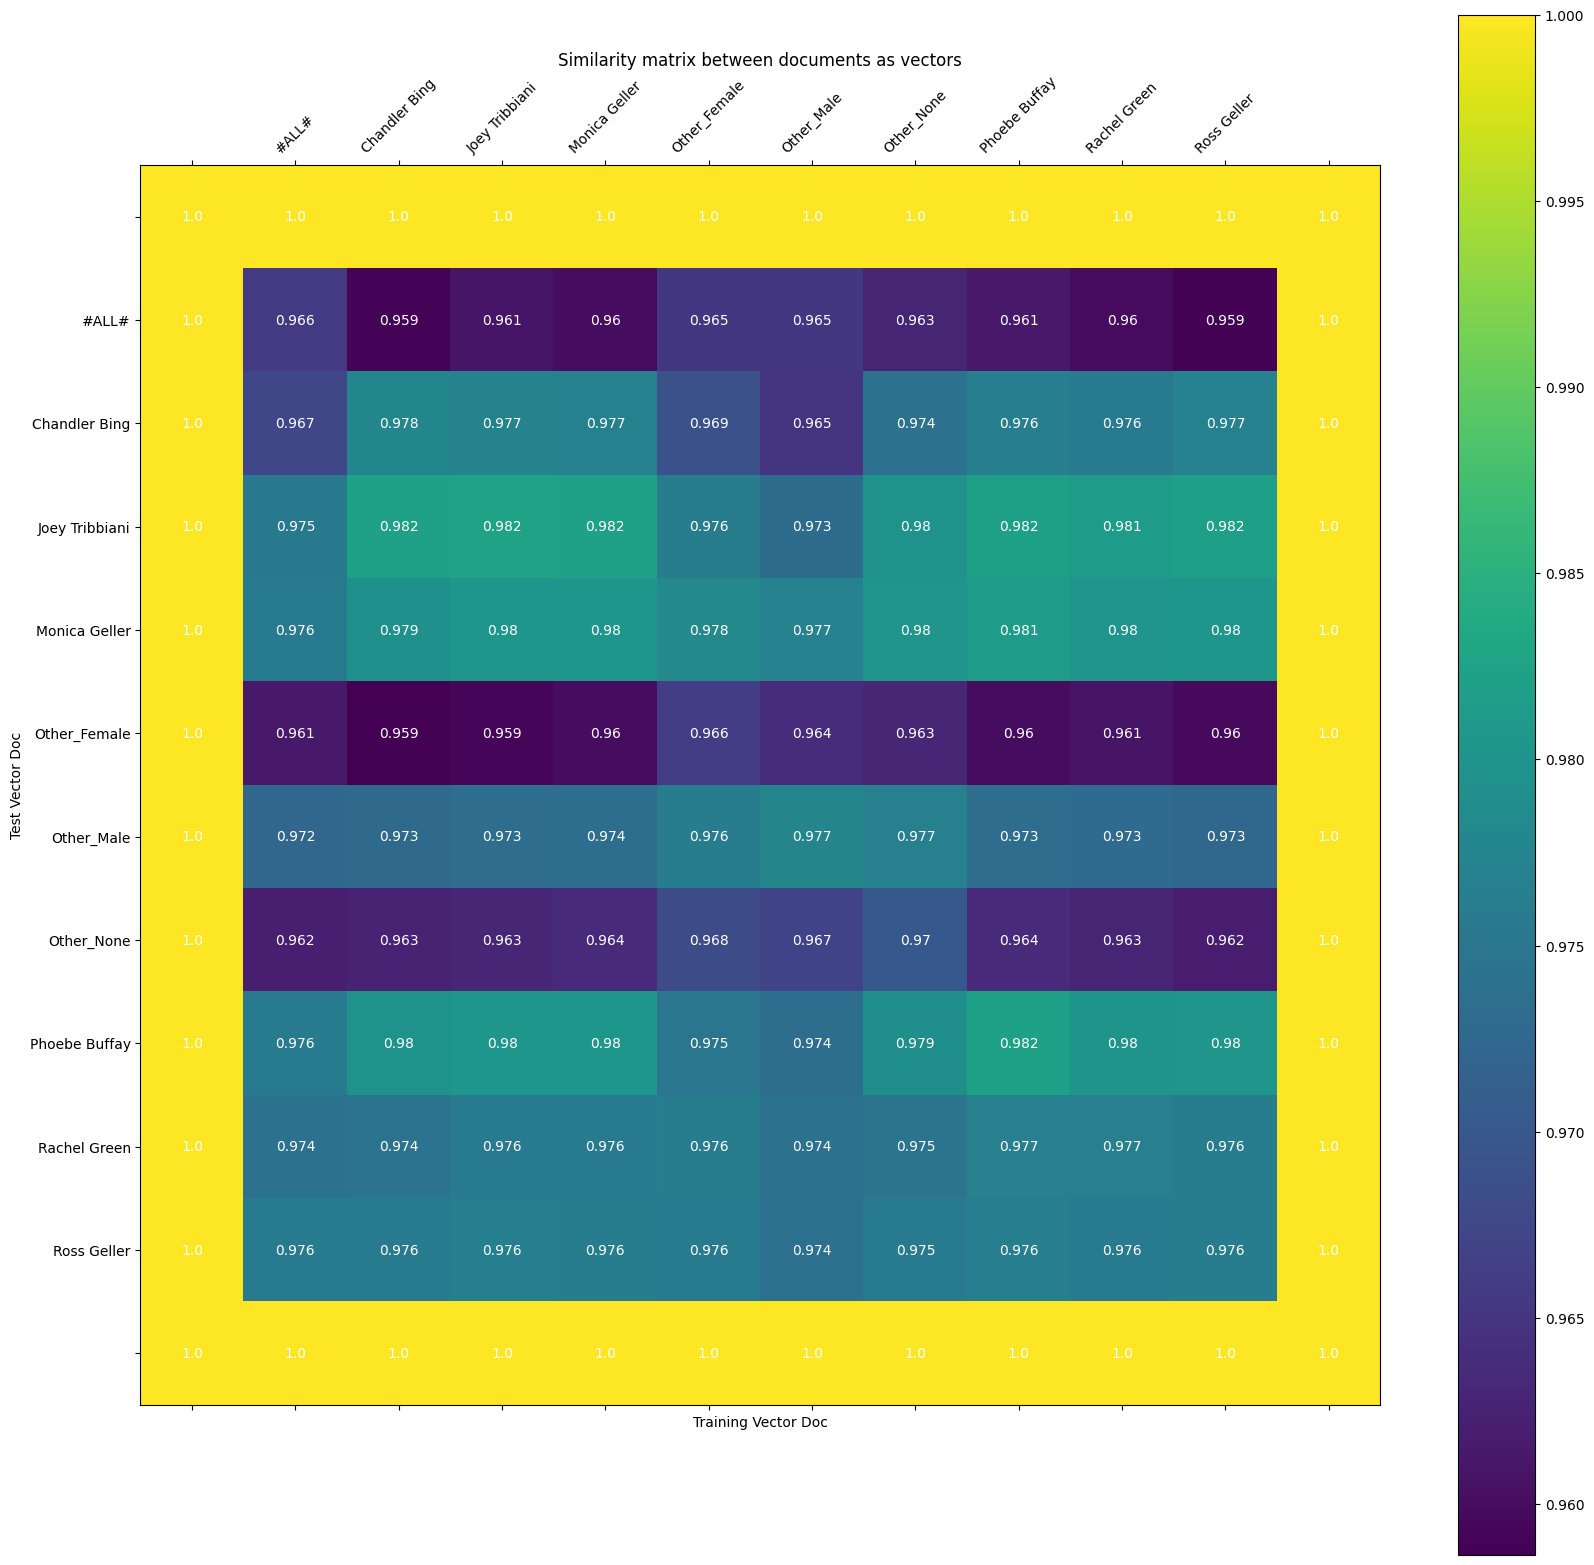

In [ ]:
plot_heat_map_similarity(df)

# Run on final test data  


In [ ]:
# redo on training data with the first 300 character lines used
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=30)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character)
test_corpus = [(name, pre_process(doc)) for name, doc in sorted(test_character_docs.items())]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)


mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

lines per character {'Monica Geller': 300, 'Joey Tribbiani': 300, 'Chandler Bing': 300, 'Phoebe Buffay': 300, '#ALL#': 215, 'Ross Geller': 300, 'Rachel Green': 300, 'Other_None': 300, 'Other_Female': 300, 'Other_Male': 300}
Num. Characters:  10 

Monica Geller Number of Words:  75713
Joey Tribbiani Number of Words:  72580
Chandler Bing Number of Words:  70739
Phoebe Buffay Number of Words:  76342
#ALL# Number of Words:  76061
Ross Geller Number of Words:  75468
Rachel Green Number of Words:  75637
Other_None Number of Words:  62745
Other_Female Number of Words:  82933
Other_Male Number of Words:  71279
total words 739497
lines per character {'Ross Geller': 30, 'Joey Tribbiani': 30, 'Chandler Bing': 30, 'Other_Female': 30, 'Other_None': 30, '#ALL#': 8, 'Monica Geller': 30, 'Rachel Green': 30, 'Phoebe Buffay': 30, 'Other_Male': 30}
Num. Characters:  10 

Ross Geller Number of Words:  6126
Joey Tribbiani Number of Words:  6008
Chandler Bing Number of Words:  4784
Other_Female Number of Wo